*This notebook is based on course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Ben Sattelberg and Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# Neural networks: convolutional networks

### Preface:  enabling GPUs on google colab

Until now we ran our neural networks on a CPU.  If you are running this notebook on google colab, you are in luck - google colab will allow you to run your code on a GPU.  Enabling a GPU is very simple:  All you need to do is navigate to Edit→Notebook Settings and select GPU from the Hardware Accelerator drop-down.
This [colab notebook](https://colab.research.google.com/notebooks/gpu.ipynb) has instructions for verifying that you are using a GPU and see the resulting speedup.


In [1]:
import numpy as np
import tensorflow as tf
import scipy.signal
import matplotlib.pyplot as plt

2023-02-20 11:11:56.089801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Let's read some data

In [2]:
tf.keras.datasets.fashion_mnist.load_data()
# This will download to ~/.keras/datasets/
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X_train /= 255
X_test /= 255

y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)

In [3]:
# This will download an 11.5 MB file to ~/.keras/datasets/
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X_train /= 255
X_test /= 255

y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)

## Convolutional Neural Networks

Previously, we had identified two main issues with fully connected networks on image tasks:
1. Unreasonable number of parameters - trillions of parameters may be necessary
2. Any exploitation of the structure of images must be learned entirely by the network.

The second problem here is not necessarily impossible to overcome, but the first is.  To reduce the number of parameters, we will look at "convolutional layers," which exploit the nature of images to provide more structured learning.  Exploiting the structure of images based loosely on the human vision system is how we will construct these layers.

<img style="width:50%;" alt="A simplified schema of the human visual pathway by Miquel Perello Nieteo CC BY-SA 4.0" src="https://upload.wikimedia.org/wikipedia/commons/b/bf/Human_visual_pathway.svg">

Convolutional layers are (somewhat loosely) inspired by human vision systems, specifically the lateral geniculate nucleus (LGN) and the visual cortex.  In the above image, everything from the visual field to the LGN can be considered as the "input" to the network that the LGN and visual cortex form.  Since there are two eyes, this is somewhat analagous to an ensemble of two networks running on slightly different inputs.

Both the LGN and visual cortex are split into a number of "layers" which perform various processing tasks while passing information from the optic nerve through.  For example, the visual cortex is split into six parts - V1 through V6.  V1, the primary visual cortex, identifies edges and lines in what is being viewed while preserving their relative locations in the image. That information is passed to deeper layers in the visual cortex.  [Biological Inspirations of Convolutional Neural Network](https://medium.com/@gopalkalpande/biological-inspiration-of-convolutional-neural-network-cnn-9419668898ac) and [Visual system](https://en.wikipedia.org/wiki/Visual_system) go more into depth on what those biological systems do.

Let's walk through how we can identify edges in images mathematically.  We'll start by looking at two images where identifying vertical or horizontal edges could help with classification:

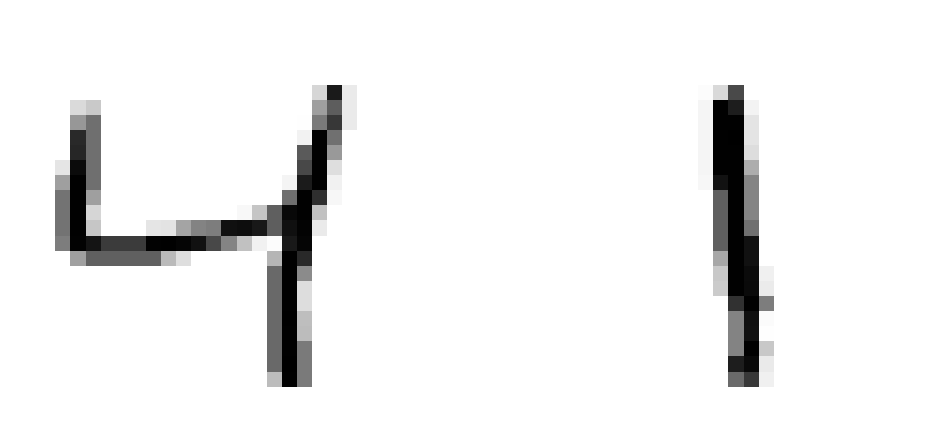

In [4]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.imshow(X_train[2, :, :].reshape(28,28), cmap='Greys')
ax.axis('off')

ax2.imshow(X_train[8, :, :].reshape(28,28), cmap='Greys')
ax2.axis('off');

We can identify the edges with a "filter" that we "convolve" over the image - we basically take a small matrix of numbers, and then for every pixel in the image we calculate the result of overlaying the matrix at that pixel.  In the below animation, the set of blue blocks are the input image, the darker blue region is where the filter is being applied, and the gray blocks are the output.

<img style="width:50%;" alt="Convolution example by Irhum Shafkat available at https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1" src="https://miro.medium.com/max/700/1*Fw-ehcNBR9byHtho-Rxbtw.gif">

The [Towards Data Science article by Irhum Shafkat](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) from which this image is used is also a useful resource for learning about convolution, and goes into more detail than this notebook does about certain aspects of them.  The paper [A Guide to Convolution Arithmetic for Deep Learning by Vincent Dumoulin and Frencesco Visin](https://github.com/vdumoulin/conv_arithmetic) and its associated GitHub repository may also be a useful resource, although the paper is somewhat involved.

If we apply the filter
$$ \begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix} $$
to the one and the four using this convolution structure, we get:

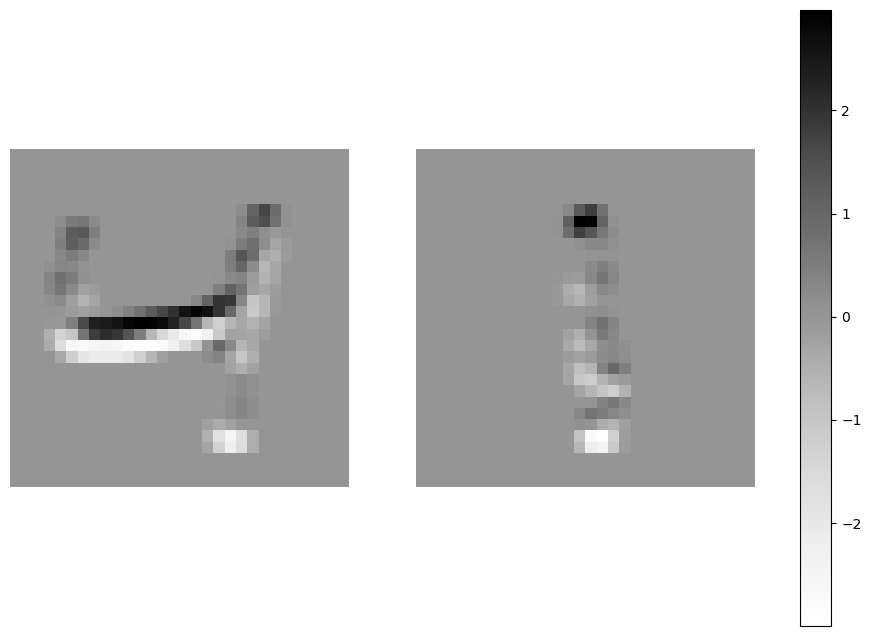

In [5]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

conv_result = scipy.signal.convolve2d(X_train[2, :, :].reshape(28, 28), np.array([[1,2,1],[0,0,0],[-1,-2,-1]]))
ax.imshow(conv_result, cmap='Greys')
ax.axis('off')

conv_result = scipy.signal.convolve2d(X_train[8, :, :].reshape(28, 28), np.array([[1,2,1],[0,0,0],[-1,-2,-1]]))
im = ax2.imshow(conv_result, cmap='Greys')
ax2.axis('off')
fig.colorbar(im, ax=[ax, ax2]);

Here edges are represented by values with high magnitude, negative or positive, which correspond to the white and black pixels.  If we look for vertical edges (with the transpose of the horizontal edge matrix), we get

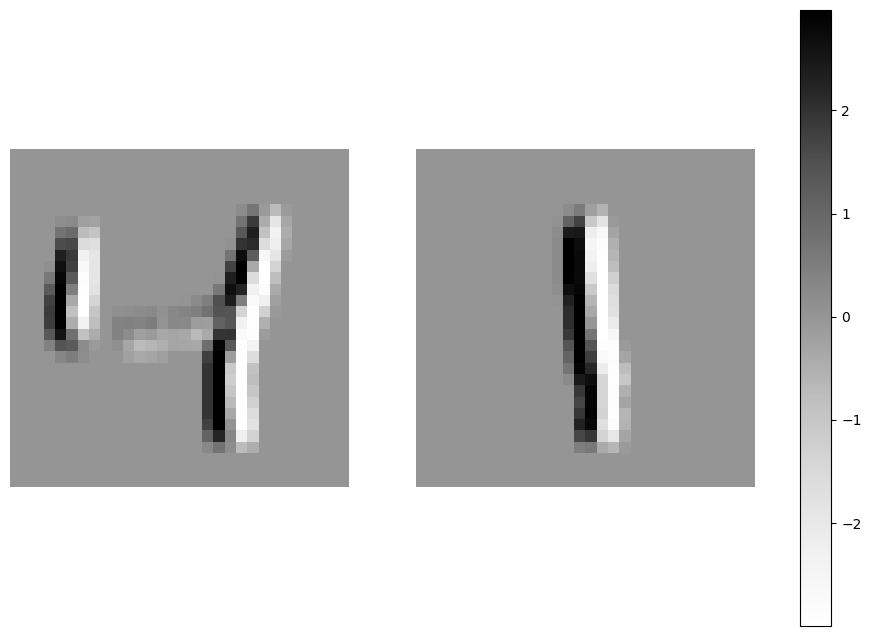

In [6]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

conv_result = scipy.signal.convolve2d(X_train[2, :, :].reshape(28, 28), np.array([[1,2,1],[0,0,0],[-1,-2,-1]]).T)
ax.imshow(conv_result, cmap='Greys')
ax.axis('off')

conv_result = scipy.signal.convolve2d(X_train[8, :, :].reshape(28, 28), np.array([[1,2,1],[0,0,0],[-1,-2,-1]]).T)
ax2.imshow(conv_result, cmap='Greys')
ax2.axis('off')
fig.colorbar(im, ax=[ax, ax2]);

This isn't *exactly* the method one would use for calculating edges in practice, partially due to the arbitrary sign issue, but it still gives an example of what convolutions do and how they can find potentially meaningful features.

There are two other notes to make:
* One of these filters only has nine parameters, but interacts with the entire image.  Using multiple filters can give us a number of meaningful features while using relatively few parameters.
* This exploits the local structure of the image to create useful features.  Because the same filter is used everywhere, we don't need to worry about finding a fully constructed structure that will give us edge detection no matter where on the image we look - that happens for free.  Converting this to a "fully connected" layer in a neural network would require 784 nodes (really 900 - see next point).
* Behavior on boundaries is important to keep in mind to avoid size issues.  As shown in the animation of convolutions, applying the 3x3 filter to every location that it doesn't run off the edge of the image, it will shrink by one pixel on each side, resulting in a 26x26 image for MNIST.  However, if we look at the size of one of the images resulting from the convolutions we calculated,

In [7]:
conv_result.shape

(30, 30)

it's not 28x28 or 26x26 - it's 30x30.  The signal subpackage from SciPy defaults to adding "padding" around the input image.  If a single "pixel" of padding is added for a 3x3 filter, we end up with an output that is the same size as the input, as shown in the figure below:

<img style="width:50%;" alt="Convolution padding example by Irhum Shafkat available at https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1" src="https://miro.medium.com/max/395/1*1okwhewf5KCtIPaFib4XaA.gif">

There are a few methods for determining what value a padding "pixel" has - the three most common are looping around the edges, extending the adjacent pixel, and setting the value to zero.  Of those, zero padding is the most common.

SciPy defaults to *two* pixels of padding on each edge, which results in one pixel being added to each edge of the output.  Keras, however, defaults to having no padding.  The amount of padding necessary to maintain the input image size also changes based on the size of the filter - a 3x3 filter needs one pixel of padding, but a 5x5 filter would need two pixels of padding.

In addition to padding, convolutional layers also have a stride parameter.  This parameter controls how far the filter moves along the original image when generating the output:

<img style="width:50%;" alt="Strides by Vincent Dumoulin and Frencesco Visin https://github.com/vdumoulin/conv_arithmetic" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides.gif">

The above stride is two, rather than the default one from earlier images, and effectively "halves" the size of the input image in each dimension.  This result in subsampling of the image, which helps to reduce the amount of data (and therefore the number of parameters) passed through the network.

Another form of subsampling is pooling, where the image is downsampled according to some algorithm.  One common method of doing this is max-pooling, where the maximum value in some region is passed as the value for the corresponding pixel in the output:

<img style="width:50%;" alt="Max Pooling by Aphex34 CC BY-SA 4.0 https://en.wikipedia.org/wiki/File:Max_pooling.png" src="https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png">

Max pooling can also give local translational invariance.  If we moved a seven in one of our images to the right slightly, we would still want it to be classified in the same way.  Traditional fully connected networks have no method for explicitly learning to do this (although convolutions can help during the training process), but max pooling gives that invariance for free in the "receptive fields" of later layers - the region of pixels in the original image that influence the value of a pixel in a later layer.

The "typical" convolutional neural network (CNN) structure is to have repeated convolutional and pooling layers, although a number of variations on this structure exist.

<img style="width:50%;" alt="Max Pooling by Aphex34 CC BY-SA 4.0 https://en.wikipedia.org/wiki/File:Typical_cnn.png" src="https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png">

The outputs of convolutional layers are often referred to as "features," as they describe abstract features of the original image.

With all of that theory, we can now construct a CNN for MNIST.  We'll start with a `Sequential` network, as we've been using, with a convolutional layer:

In [6]:
conv_network = tf.keras.Sequential()
conv_network.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(2,2), activation='relu', input_shape=(28,28,1)))

2023-02-20 11:20:41.490535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


This convolutional layer has 32 3x3 filters with ReLU activiations and no padding.  It also expects 28x28 pixel images with a single "channel."  The stride component of this layer will also roughly half the size of the output from that of the input.  The net result of this layer will be a 13x13 32 channel "image" (one channel for each filter).  

We use strides here rather than max pooling as strides result in faster computation (although for MNIST proper max pooling can slightly increase accuracy.

The next thing we do is the exact same layer:

In [7]:
conv_network.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(2,2), activation='relu'))

This will result in a 6x6 32 channel image.  We repeat this a third time:

In [8]:
conv_network.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(2,2), activation='relu'))

The convolution will shrink the images to 2x2 32 channel images.  One note to make about channels is that when a convolutional filter is applied to a multi-channel input, it's evaluated for each channel and the results are summed to calculate the value at a given pixel.

Next, we want to have a dense layer before the final classification, so we must "flatten" the image to an 128=2\*2\*32 dimensional vector:

In [9]:
conv_network.add(tf.keras.layers.Flatten())

After that, we'll apply the same network structure we had for the fully connected network:

In [10]:
conv_network.add(tf.keras.layers.Dense(100, activation='relu'))
conv_network.add(tf.keras.layers.Dense(10, activation='softmax'))

### Question
Given this network structure, with multiple convolutional layers before the same dense layer we saw previously, do you expect it to have (roughly)
1. Half the parameters than the fully connected network
2. The same number of parameters as the fully connected network
3. Double the number of parameters of the fully connected network
4. 10x more parameters than the fully connected network
5. 100x more parameters than the fully connected network

### Back to the network

Now that we have the network setup, we can train it.  Each epoch will take longer than the fully connected network due to the complexity of the calculations that must be done.

In [11]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Adam()

conv_network.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
history_conv = conv_network.fit(X_train, y_train_one_hot,
                                validation_data = (X_test, y_test_one_hot),
                                batch_size=100, epochs=10, verbose=1)

Epoch 1/10
600/600 [==============================] - 11s 15ms/step - loss: 0.3428 - accuracy: 0.8974 - val_loss: 0.1268 - val_accuracy: 0.9591
Epoch 2/10
600/600 [==============================] - 8s 13ms/step - loss: 0.1051 - accuracy: 0.9688 - val_loss: 0.0745 - val_accuracy: 0.9770
Epoch 3/10
600/600 [==============================] - 8s 13ms/step - loss: 0.0747 - accuracy: 0.9772 - val_loss: 0.0613 - val_accuracy: 0.9810
Epoch 4/10
600/600 [==============================] - 8s 14ms/step - loss: 0.0590 - accuracy: 0.9818 - val_loss: 0.0591 - val_accuracy: 0.9826
Epoch 5/10
600/600 [==============================] - 8s 14ms/step - loss: 0.0490 - accuracy: 0.9844 - val_loss: 0.0520 - val_accuracy: 0.9847
Epoch 6/10
600/600 [==============================] - 9s 14ms/step - loss: 0.0415 - accuracy: 0.9867 - val_loss: 0.0463 - val_accuracy: 0.9857
Epoch 7/10
600/600 [==============================] - 9s 15ms/step - loss: 0.0354 - accuracy: 0.9887 - val_loss: 0.0468 - val_accuracy: 0.985

In [14]:
print('Final loss: {}, test accuracy: {}'.format(*map(lambda x: round(x, 4), conv_network.evaluate(X_test, y_test_one_hot, verbose=0))))

Final loss: 0.0486, test accuracy: 0.9855


We can also look at the summary, which confirms the size of the output of each layer:

In [15]:
conv_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 32)          9248      
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 100)               12900     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 32,726
Trainable params: 32,726
Non-traina

We also see that this network has half the parameters of the fully connected network, despite its increased representational complexity.

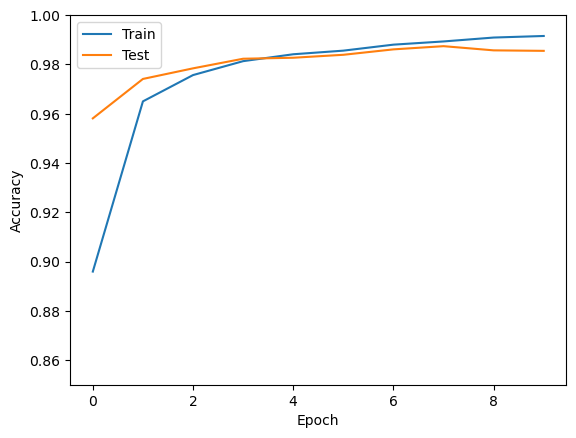

In [16]:
plt.plot(history_conv.history['accuracy'], label='Train')
plt.plot(history_conv.history['val_accuracy'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.85, 1]);

This network trains to a good solution very quickly (when reading this plot, note that there are half as many epochs total as the previous networks due to the increased training time) and ends with slightly more than 98.5% accuracy on the test set, an increase over the fully connected network's 97.5%.

This may not seem like a significant increase over the fully connected network, but there are two points that make it impressive:
1. This network requires half as many parameters
2. Raw percentages are useful, but don't tell the whole story.  Increasing from 50% to 75% accuracy is a raw increase of 25%, and halves the error rate from 50% to 25%.  Increasing from 98% to 99% is a raw increase of 1%, but it also halves the error rate from 2% to 1%.  In general, as the accuracy increases, increasing it further becomes more difficult and can be suprisingly beneficial.

Let's also look at a few of the images the network misclassifies:

313/313 [==============================] - 1s 3ms/step


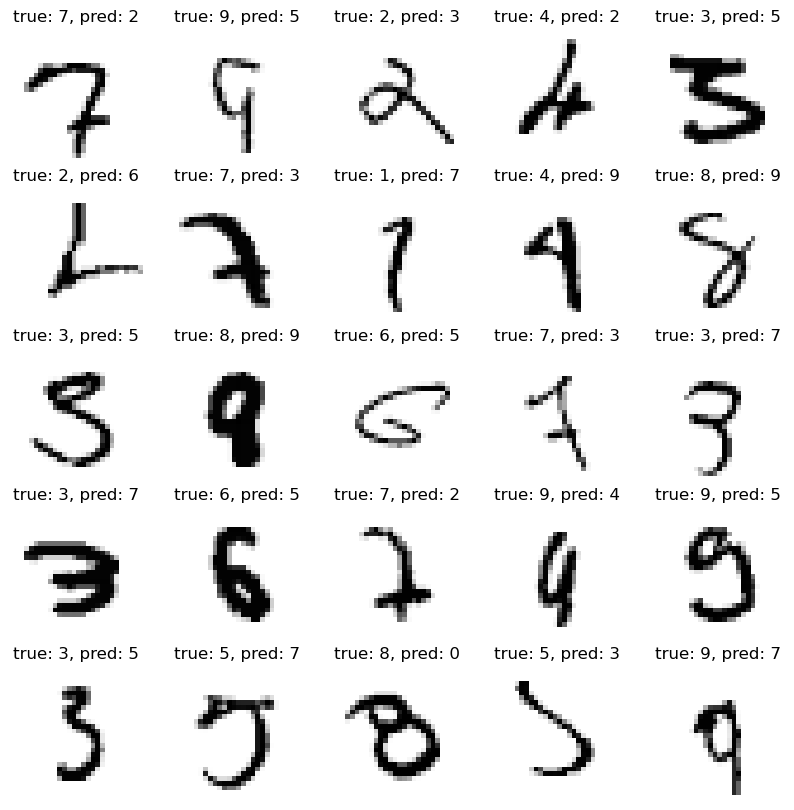

In [12]:
pred = np.argmax(conv_network.predict(X_test), axis=1)
incorrect_bool_array = y_test != pred

y_test_incorrect = y_test[incorrect_bool_array]
X_test_incorrect = X_test[incorrect_bool_array]
pred_incorrect = pred[incorrect_bool_array]

fig, axes = plt.subplots(5, 5, figsize=(10,10))

for i in range(5):
    for j in range(5):
        axes[i,j].imshow(X_test_incorrect[i*5 + j, :, :].reshape(28,28), cmap='Greys')
        axes[i,j].set_title('true: {}, pred: {}'.format(y_test_incorrect[i*5+j], pred_incorrect[i*5+j]))
        axes[i,j].axis('off')

There are genuine mistakes in this set of images, but there are also images that for various reasons, such as poor cropping or poor handwriting, are difficult to classify.  Something that is not uncommon is datasets having a certain amount of label noise.  For example, in one image classification dataset, there are "lemon," "orange," and "bowl" classifications, and an image of lemons and oranges in a bowl has a "true" classification that is only one of the three.

### Exercise

Construct a network that achieves higher than 99% accuracy within ten epochs. Max pooling may be useful for this over using strides in every layer, and a max pooling layer can be added using

```conv_network.add(keras.layers.MaxPooling2D(pool_size=(2,2)))```

### Comments
* We will talk more about "real" neural networks next time, and work with a dataset that isn't as simple to achieve success on.
* In the last notebook we provided some intuition into what the networks are doing.  With the high input dimension and complexity of these networks, that kind of analysis is now significantly more difficult.  However, there are resources that provide visualizations of what certain parts of the network are doing - [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/) is one such resource that provides an interactive analysis of some features.  The host website ([distill.pub](https://distill.pub)) is also a good resource for learning about complex topics in neural networks.